# Obesity and Venues (Chicago)

## Table of contents
<ol>
    <li> Introduction </li>
    <li> Data </li>
    <li> Methodology </li>
    <li> Results </li>
    <li> Discussion </li>
    <li> Conclusion </li>
</ol>

## 1. Introduction



There is a public concern regarding with overweight and obesity all around the world. Nowadays, there is a huge percentage of americans suffering with obesity and children are also in danger. Factors such as bad eating habits, sedentarism, and the fast living pace are increasing the junk food consume and decreasing physical activity. 

In this project we will try to analyze similarities between community areas in the city of Chicago, according with their percentage of population suffering from obesity, in terms of the most popular venues in each area. The main objective is to verify whether the venues are affecting people's weight. This report will be targeted to the Government (Specially Health Area), as well as to the owners of this venues so that they can also take corrective actions.  This information is also very useful for Centers for Disease Control and Prevention (CDC), which is an entity in charge of protect community health. They are developing a project called Communities Putting Prevention to Work (CPPW), which is an initiative designed to “make healthy living easier by promoting environmental changes at the local level”. 

For the CDC, it would be interesting to have an analysis that allows them to take decisions                 regarding venues that are affecting positively or negatively the population's weight. If it is possible to verify whether there exists a relationship between the venues and the amount of obese people, some action plans can be taken to improve food quality in determined zones and create incentives for people so that they can make exercise actively. It would be cheaper to prevent this behavior from the source, rather than spending money in gastric bypassing, surgeries and heart diseases treatments needed because of obesity.

The main idea with this project would be to compare venues in the community areas and by using clustering verify if there is a pattern in data that can be related with high/low obesity levels in each area, so that the Government can take any action e.g. giving rewards for restaurants to control portions and food quality, subsidize gym subscriptions for people, and so on. 



## 2. Data


Based on our problem, we have to consider the following parameters:
<ul>
    <li>Percentage of Obesity in each Community Area</li>
    <li>Which are the most popular venues per area regarding food and exercise</li>
    <li>How similar are the community areas according to their most popular venues</li>
    <li>How similar are the results from community areas’ venues to the percentage of obesity per community area.</li>
</ul>

We will need to use data that describes the percentage of obesity per Community Area, that is going to be retrieved from the Chicago Health Atlas. Data should come with the name of the community area, and the obesity percentage, e.g. Community Area Name: Englewood, Obesity Percentage:  30%. Then, we need to retrieve the most popular venues per Community Area, as well as it's category to see if the type of food, or place for exercising can affect the obesity rates. For obtaining this information we will use Foursquare API. In this case, we will only consider two types of venues: 

<ul>
    <li>Food</li>
    <li>Outdoors and Recreation</li>
</ul>

The idea is to retrieve the 100 most popular venues with their name, category, latitude and longitude e.g. Name: Hai Yen, Category: Vietnamese Restaurant Latitude: 41.97328297968702, longitude: -87.65705585461119 

Having this information we can compare the different categories and use the K-Means clustering algorithm to verify how similar are the community areas and if it exists a relation between the    category of food and Outdoors and Recreation venues, and the obesity percentage per community area. We will also use geographic data in GeoJson format to display the geographic limits of community areas, and use a palette to display colors according to their obesity percentages. This data can be found in the Chicago Data Portal. For obtaining longitude and latitude per Community Area we will use Nominatim API.


### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json

from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import requests
from pandas.io.json import json_normalize

### Obtaining data

First thing we will do is to obtain data related with obesity. This data can be found in https://www.chicagohealthatlas.org/indicators/adult-obesity. We are adding this data, which is in excel spreadsheet format, to this repository. This file is called 'Adult_Obesity.xlsx'

In [12]:
#Creating the dataframe using the data in the spreadsheet
df_obesity=pd.read_excel('Adult_Obesity.xlsx')
df_obesity.head()

,Category,SubCategory,Indicator,Year,Geography,Geo_Group,Geo_ID,Demography,Demo_Group,Number,...,Upper_95CI_Age_Adj_Rate,Percent,Lower_95CI_Percent,Upper_95CI_Percent,Weight_Number,Weight_Percent,Lower_95CI_Weight_Percent,Upper_95CI_Weight_Percent,Map_Key,Flag
0,Morbidity,Chronic Disease,Adult obesity,2001,City,Chicago,606,Race-ethnicity,All race-ethnicities,NaN,...,NaN,NaN,NaN,NaN,438000,21,17.4,24.5,NaN,G
1,Morbidity,Chronic Disease,Adult obesity,2001,City,Chicago,606,Race-ethnicity,Hispanic or Latino,NaN,...,NaN,NaN,NaN,NaN,68000,19.4,11,27.8,NaN,G
2,Morbidity,Chronic Disease,Adult obesity,2001,City,Chicago,606,Race-ethnicity,Non-Hispanic African American or Black,NaN,...,NaN,NaN,NaN,NaN,208000,28.6,21.7,35.5,NaN,G
3,Morbidity,Chronic Disease,Adult obesity,2001,City,Chicago,606,Race-ethnicity,Non-Hispanic Asian or Pacific Islander,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Morbidity,Chronic Disease,Adult obesity,2001,City,Chicago,606,Race-ethnicity,Non-Hispanic White,NaN,...,NaN,NaN,NaN,NaN,123000,15.5,10.8,20.1,NaN,G


In [13]:
df_obesity.shape

(321, 27)

We can see there is a lot of information that we will not need to use, for example old information that comes from 2001. We are currently interested in the last report, so we will take it from the period of 2015-2017 per community area. Also we will use from this data only the weight percentage, as well as the information of the Community Area. We are not evaluating any specific ethnicity, or age.

In [14]:
cond=df_obesity['Year']=='2015-2017' 
cond2=df_obesity['Geography']=='Community Area'
df_obesity=df_obesity[cond & cond2]

df_obesity=df_obesity[['Geo_Group', 'Geo_ID', 'Weight_Percent']]
df_obesity.reset_index(drop=True, inplace=True)
df_obesity.shape

(77, 3)

In [15]:
df_obesity.head()

,Geo_Group,Geo_ID,Weight_Percent
0,1-Rogers Park,1,33.7
1,2-West Ridge,2,24
2,3-Uptown,3,20.9
3,4-Lincoln Square,4,20.3
4,5-North Center,5,18.1


It would be better not to have a number before the name of the community area, so we will remove it

In [16]:
df_obesity['Geo_Group']=df_obesity['Geo_Group'].apply(lambda a:a.split('-', 1)[1])
df_obesity.head()

,Geo_Group,Geo_ID,Weight_Percent
0,Rogers Park,1,33.7
1,West Ridge,2,24
2,Uptown,3,20.9
3,Lincoln Square,4,20.3
4,North Center,5,18.1


To avoid empty values, we will replace them by 0. We will also put the Geo_Group names in UpperCase and we will remove any left empty space

In [17]:
df_obesity.replace(' ', 0, inplace=True)
df_obesity['Geo_Group']=df_obesity['Geo_Group'].str.upper()
df_obesity['Geo_Group']=df_obesity['Geo_Group'].apply(lambda a:a.strip())
df_obesity.Weight_Percent = df_obesity.Weight_Percent.astype(float)
df_obesity.head(5)

,Geo_Group,Geo_ID,Weight_Percent
0,ROGERS PARK,1,33.7
1,WEST RIDGE,2,24.0
2,UPTOWN,3,20.9
3,LINCOLN SQUARE,4,20.3
4,NORTH CENTER,5,18.1


As we will need to compare Community Areas keeping in mind the obesity percentage, we will delete the rows that have zero value

In [49]:
condition=df_obesity['Weight_Percent']!=0
df_obesity=df_obesity[condition]
df_obesity.reset_index(drop=True, inplace=True)#drop True avoids to add the old index as a new column
df_obesity.shape

(74, 5)

Let's visualize this data by using a Choropleth map. We have obtained boundaries per community area in geojson format from the Chicago Data portal in https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6. We will also add this data to the repository, with some modifications to allow us to work with it.

In [53]:
#We are creating this function because we will need the choropleth
#map in the following visualizations
def choropleth_map_chicago():
    geolocator=Nominatim(user_agent='explorer')
    location=geolocator.geocode('Chicago')
    lon=location.longitude
    lat=location.latitude
    print(lat, lon)
    #Create map
    chicago_map=folium.Map(location=(lat,lon),zoom_start=10)
    chicago_map.choropleth(
        geo_data=chicago_geo,
        data=df_obesity,
        columns=['Geo_Group','Weight_Percent'],
        key_on='feature.properties.community',
        fill_color='BuPu',
        fill_opacity=0.8
        #line_opacity=0.2
        )
    folium.LayerControl().add_to(chicago_map)
    
    return chicago_map

def embed_map(m):
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='750px')


In [54]:
chicago_geo = r'Boundaries2-copia.json'
chicago_map=choropleth_map_chicago()
embed_map(chicago_map)

41.8755616 -87.6244212


Now we will add another column to our dataframe with information of latitude and longitude for each community area. We will obtain this data using Nominatim

In [55]:
geolocator=Nominatim(user_agent='explorer')
for i, val in enumerate(df_obesity['Geo_Group']):
    
    try:
        location=geolocator.geocode(val+' '+'Chicago'+' '+'Illinois')
        lon=location.longitude
        lat=location.latitude
        df_obesity.loc[i,'lat']=lat
        df_obesity.loc[i,'lon']=lon
        print (val+' '+'Chicago', lat, lon)
    except(AttributeError):
        location=geolocator.geocode(val+' '+'Chicago')
        lon=location.longitude
        lat=location.latitude
        df_obesity.loc[i,'lat']=lat
        df_obesity.loc[i,'lon']=lon
        print (val+' '+'Chicago', lat, lon)
    except:
        location=geolocator.geocode(val+' '+'Illinois')
        lon=location.longitude
        lat=location.latitude
        df_obesity.loc[i,'lat']=lat
        df_obesity.loc[i,'lon']=lon
        print (val+' '+'Chicago', lat, lon)
df_obesity.head(10)

ROGERS PARK Chicago 42.01053135 -87.6707481966481
WEST RIDGE Chicago 42.0035482 -87.6962426
UPTOWN Chicago 41.9666299 -87.6555458
LINCOLN SQUARE Chicago 41.8909105 -87.6253481
NORTH CENTER Chicago 41.9561073 -87.6791596
LAKEVIEW Chicago 41.9439185 -87.6540759
LINCOLN PARK Chicago 41.9216992 -87.647832
NEAR NORTH SIDE Chicago 41.9000327 -87.6344975
EDISON PARK Chicago 42.0057335 -87.8140036737589
NORWOOD PARK Chicago 41.9855895 -87.8005772013227
JEFFERSON PARK Chicago 41.9697375 -87.7631179
FOREST GLEN Chicago 41.99175155 -87.7516732983677
NORTH PARK Chicago 41.98495475 -87.7229343538787
ALBANY PARK Chicago 41.9719367 -87.7161739
PORTAGE PARK Chicago 41.9578093 -87.7650594
IRVING PARK Chicago 41.953365 -87.7364471
DUNNING Chicago 41.952809 -87.7964493
MONTCLARE Chicago 41.9253091 -87.8008931
BELMONT CRAGIN Chicago 41.9316983 -87.7686699
HERMOSA Chicago 41.928643 -87.7345019
AVONDALE Chicago 41.9389208 -87.711168
LOGAN SQUARE Chicago 41.9283996 -87.7067641113273
HUMBOLDT PARK Chicago 41.

,Geo_Group,Geo_ID,Weight_Percent,lat,lon
0,ROGERS PARK,1,33.7,42.010531,-87.670748
1,WEST RIDGE,2,24.0,42.003548,-87.696243
2,UPTOWN,3,20.9,41.966630,-87.655546
3,LINCOLN SQUARE,4,20.3,41.890910,-87.625348
4,NORTH CENTER,5,18.1,41.956107,-87.679160
5,LAKEVIEW,6,16.8,41.943919,-87.654076
6,LINCOLN PARK,7,15.8,41.921699,-87.647832
7,NEAR NORTH SIDE,8,13.8,41.900033,-87.634497
8,EDISON PARK,9,19.7,42.005733,-87.814004
9,NORWOOD PARK,10,20.9,41.985590,-87.800577


### Foursquare

Now we will examine two different types of venues considered to be the ones with more influence related with obesity. These venues are Restaurants and Exercising places. First we will use our credentials and we will start with the restaurant's category. We will obtain the 100 most popular restaurants per Community Area


In [312]:
CLIENT_ID = '.....' # your Foursquare ID
CLIENT_SECRET = '.....' # your Foursquare Secret
VERSION = '.....'
CAT_ID='4d4b7105d754a06374d81259' #Category ID for restaurants

In [57]:
def getPopularVenues(names, longitudes, latitudes, nvenues, catid):
    #This function will obtain the n-most popular venues per category id
    df_venues=pd.DataFrame(columns=['CA','Name','Category','Lat','Lon'])
    n=0
    for CA, lon, lat in zip(names, longitudes, latitudes):
        url='http://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, nvenues, catid)
        results=requests.get(url).json()
        res=results['response']['groups'][0]['items']
        for i, values in enumerate(res):
            i=i+n
            df_venues.loc[i,'CA']=CA
            df_venues.loc[i,'Name']=values['venue']['name']
            df_venues.loc[i,'Category']=values['venue']['categories'][0]['name']
            df_venues.loc[i,'Lat']=values['venue']['location']['lat']
            df_venues.loc[i,'Lon']=values['venue']['location']['lng']
        n=i
            
    return df_venues

In [58]:
number_of_venues=100
df_restaurants=getPopularVenues(df_obesity['Geo_Group'], df_obesity['lon'], df_obesity['lat'], number_of_venues, CAT_ID)
df_restaurants.head()

,CA,Name,Category,Lat,Lon
0,ROGERS PARK,El Famous Burrito,Mexican Restaurant,42.0104,-87.6742
1,ROGERS PARK,Taqueria & Restaurant Cd. Hidalgo,Mexican Restaurant,42.0116,-87.6745
2,ROGERS PARK,Smack Dab Bakery,Bakery,42.0045,-87.6731
3,ROGERS PARK,J.B. Alberto's Pizza,Pizza Place,42.0079,-87.6651
4,ROGERS PARK,Smack Dab,Bakery,42.0093,-87.6662


let's see how many restaurants we have obtained

In [59]:
df_restaurants.shape

(6903, 5)

After having obtained the 100 most popular restaurants per community area, we will do the same with physical activity, by retrieving the 100 most popular venues in the category **Outdoors and Recreation**

In [60]:
CAT_ID='4d4b7105d754a06377d81259'
df_sports=getPopularVenues(df_obesity['Geo_Group'], df_obesity['lon'], df_obesity['lat'], number_of_venues, CAT_ID)
df_sports.head()

,CA,Name,Category,Lat,Lon
0,ROGERS PARK,Loyola Park,Park,42.0114,-87.6624
1,ROGERS PARK,Loyola Beach,Beach,42.009,-87.6595
2,ROGERS PARK,Leone Beach,Park,42.0131,-87.6636
3,ROGERS PARK,Pottawattomie Park,Park,42.0151,-87.6769
4,ROGERS PARK,Howard Beach Park,Playground,42.0189,-87.6641


In [48]:
df_sports.shape

(6706, 5)

Now we have all the data we need to start our analysis. We have obtained the 100 most popular venues regarding exercise and food, as well as obesity data. Now it is time to verify if there is a relation between venues and obesity data.

## 3. Methodology


In the first step we have obtained the 100 most popular venues in **restaurants** and **outdoors and recreation** categories by using the foursquare API, as well as **Obesity Percentage** from Chicago Health Atlas portal, to see if this type of venues are affecting obesity index in the community areas of Chicago.

With all the data collected, we will analyze the different sub-categories of the venues and obtain the most popular ones per Community Area. Initially, we will make a separate analysis with restaurants and another with sports by creating clusters to see if there is an independent relation between each of them and the Obesity values. We will display this information in the choropleth map, so that we can identify visually how this values can be related, if so.

Finally, we will merge Restaurants and Outdoors and Recreation data, to see the influence of both categories in the obesity index by creating clusters as we did in the previous step.




### Restaurants

Let's start by checking which are the most popular categories. For this, we need to use one hot encoding to count the values per category, per Community Area.

In [61]:
df_rest=pd.get_dummies(df_restaurants['Category'])
df_rest['CA']=df_restaurants['CA']
cols=df_rest.columns.tolist()
ca=cols[-1:]
col=cols[:-1]
columns=ca+col
df_rest=df_rest[columns]
df_rest.head()

,CA,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ROGERS PARK,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ROGERS PARK,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


This data is very sparse and we need a general overview per community area, so we will obtain the mean per community area 

In [63]:
df_mean=df_rest.groupby('CA').mean()
df_mean.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
CA,,,,,,,,,,,,,,,,,,,,,
ALBANY PARK,0.010101,0.000000,0.010101,0.0,0.0,0.050505,0.000000,0.000000,0.020202,0.0,...,0.020202,0.0,0.000000,0.0,0.040404,0.0,0.0,0.0,0.020202,0.010101
ARCHER HEIGHTS,0.000000,0.000000,0.032258,0.0,0.0,0.000000,0.010753,0.000000,0.021505,0.0,...,0.064516,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.010753
ASHBURN,0.000000,0.000000,0.040404,0.0,0.0,0.000000,0.000000,0.010101,0.010101,0.0,...,0.000000,0.0,0.000000,0.0,0.010101,0.0,0.0,0.0,0.000000,0.020202
AUBURN GRESHAM,0.000000,0.000000,0.060606,0.0,0.0,0.000000,0.000000,0.000000,0.020202,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.040404
AUSTIN,0.000000,0.010101,0.060606,0.0,0.0,0.020202,0.040404,0.000000,0.020202,0.0,...,0.000000,0.0,0.010101,0.0,0.020202,0.0,0.0,0.0,0.010101,0.000000


Let's find the 10th most popular food categories per Community Area

In [65]:
def mostpop(df, n):
    col=list(range(0,n))
    lists=[]
    for i in col:
        i=i+1
        element=str(i)+ ' most popular'
        lists.append(element)
    largest=[]
    for ca in df:
        lar=df.nlargest(n, ca).index
        largest.append(lar)
        
    df_mostpop=pd.DataFrame(largest, columns=lists, index=df.columns)
    

        #cond=ca.isin(lar)
    #ind=df[cond].index
   # print(lar)
    return df_mostpop

df_trans=df_mean.T
df_trans.head()
df_popular=mostpop(df_trans, 10)    
df_popular.head()

,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
CA,,,,,,,,,,
ALBANY PARK,Sandwich Place,Pizza Place,Mexican Restaurant,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Diner,Thai Restaurant,Café
ARCHER HEIGHTS,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Taco Place,Café,Donut Shop,Seafood Restaurant,American Restaurant,Fried Chicken Joint
ASHBURN,Sandwich Place,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,American Restaurant,Donut Shop,Breakfast Spot,Chinese Restaurant
AUBURN GRESHAM,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Seafood Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Donut Shop,Pizza Place,Wings Joint
AUSTIN,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Sandwich Place,American Restaurant,Seafood Restaurant,BBQ Joint,Café,Chinese Restaurant,Italian Restaurant


Having obtained these values, we will use clustering to see how similar are our community areas regarding with restaurants. We will choose 4 clusters, because we want to classify community areas in 4 regions according to their weight percentage.


In [289]:
nclusters=4
K_means=KMeans(init='k-means++', n_clusters=nclusters, n_init=12)
K_means.fit(df_mean)
K_means.labels_[0:10]

array([3, 1, 3, 0, 0, 0, 3, 1, 0, 2])

Let's create a new dataframe with our obtained values

In [290]:
df_data=df_obesity.copy()
df_data.sort_values(by='Geo_Group', axis=0, inplace=True)
df_data.insert(loc=5, column='Cluster', value=K_means.labels_)
df_data.head()

,Geo_Group,Geo_ID,Weight_Percent,lat,lon,Cluster
13,ALBANY PARK,14,23.9,41.971937,-87.716174,3
53,ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,1
66,ASHBURN,70,36.4,41.747533,-87.711163,3
67,AUBURN GRESHAM,71,42.3,41.750474,-87.664304,0
24,AUSTIN,25,38.9,41.887876,-87.764851,0


Now, we will add to this table, the information regarding with the 10 most popular restaurant venues

In [291]:
df_data.set_index('Geo_Group', inplace=True)
df_data=df_data.join(df_popular)
df_data

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,3,Sandwich Place,Pizza Place,Mexican Restaurant,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Diner,Thai Restaurant,Café
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,1,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Taco Place,Café,Donut Shop,Seafood Restaurant,American Restaurant,Fried Chicken Joint
ASHBURN,70,36.4,41.747533,-87.711163,3,Sandwich Place,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,American Restaurant,Donut Shop,Breakfast Spot,Chinese Restaurant
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,0,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Seafood Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Donut Shop,Pizza Place,Wings Joint
AUSTIN,25,38.9,41.887876,-87.764851,0,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Sandwich Place,American Restaurant,Seafood Restaurant,BBQ Joint,Café,Chinese Restaurant,Italian Restaurant
AVALON PARK,45,55.7,41.745035,-87.588658,0,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Chinese Restaurant,Donut Shop,Caribbean Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Wings Joint
AVONDALE,21,40.8,41.938921,-87.711168,3,Mexican Restaurant,Sandwich Place,Italian Restaurant,Latin American Restaurant,Café,Diner,Pizza Place,Chinese Restaurant,Donut Shop,Fast Food Restaurant
BELMONT CRAGIN,19,32.4,41.931698,-87.768670,1,Sandwich Place,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Diner,Donut Shop,Fried Chicken Joint,Greek Restaurant,American Restaurant,Cuban Restaurant
BEVERLY,72,32.6,41.718153,-87.671767,0,Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Donut Shop,Mexican Restaurant,Seafood Restaurant,Chinese Restaurant,Breakfast Spot,Burger Joint


Having this clusters, we will visualize them in our Choropleth map

In [292]:
x=np.arange(nclusters)
ys=[i+x+(i*x)**2 for i in range(nclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

markers_colors=[]

for lat, lon, poi, cluster in zip(df_data['lat'], df_data['lon'], df_data.index.values, df_data['Cluster'] ):
    label=folium.Popup(str(poi) + ' Cluster '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        popup=label).add_to(chicago_map)

embed_map(chicago_map)

We can see that there exists a relationship between the less obese region and the type of venues. Let's see which type of venues are predominating in each cluster

In [293]:
cond0=df_data['Cluster']==0
df_data[cond0]

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,0,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Seafood Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Donut Shop,Pizza Place,Wings Joint
AUSTIN,25,38.9,41.887876,-87.764851,0,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Sandwich Place,American Restaurant,Seafood Restaurant,BBQ Joint,Café,Chinese Restaurant,Italian Restaurant
AVALON PARK,45,55.7,41.745035,-87.588658,0,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Chinese Restaurant,Donut Shop,Caribbean Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Wings Joint
BEVERLY,72,32.6,41.718153,-87.671767,0,Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Donut Shop,Mexican Restaurant,Seafood Restaurant,Chinese Restaurant,Breakfast Spot,Burger Joint
CALUMET HEIGHTS,48,31.1,41.730035,-87.579213,0,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Fried Chicken Joint,Pizza Place,Southern / Soul Food Restaurant,Café,Caribbean Restaurant,Donut Shop,American Restaurant
CHATHAM,44,39.5,41.741145,-87.612548,0,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Seafood Restaurant,Chinese Restaurant,Pizza Place,Mexican Restaurant,American Restaurant,Caribbean Restaurant,Donut Shop
EAST GARFIELD PARK,27,33.4,41.880866,-87.702833,0,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Pizza Place,Restaurant,Donut Shop,American Restaurant,Bakery,Chinese Restaurant,Deli / Bodega
EAST SIDE,52,35.5,41.694618,-87.533387,0,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Sandwich Place,Fried Chicken Joint,Café,American Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Burger Joint
ENGLEWOOD,68,40.7,41.779756,-87.645884,0,Fast Food Restaurant,Fried Chicken Joint,American Restaurant,Sandwich Place,Seafood Restaurant,Chinese Restaurant,Donut Shop,BBQ Joint,Pizza Place,Caribbean Restaurant


In this Cluster, Fast Food Restaurants are predominating, as well as Sandwich and Pizza places. Let's See the following cluster:

In [294]:
cond1=df_data['Cluster']==1
df_data[cond1]

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,1,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Taco Place,Café,Donut Shop,Seafood Restaurant,American Restaurant,Fried Chicken Joint
BELMONT CRAGIN,19,32.4,41.931698,-87.768670,1,Sandwich Place,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Diner,Donut Shop,Fried Chicken Joint,Greek Restaurant,American Restaurant,Cuban Restaurant
BRIGHTON PARK,58,36.4,41.818922,-87.698942,1,Mexican Restaurant,Pizza Place,Sandwich Place,Taco Place,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Donut Shop,Fried Chicken Joint,Hot Dog Joint
CHICAGO LAWN,66,41.6,41.775033,-87.696441,1,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Fried Chicken Joint,American Restaurant,Taco Place,Chinese Restaurant,Seafood Restaurant,Donut Shop
GAGE PARK,63,22.8,41.795033,-87.696164,1,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Taco Place,Fried Chicken Joint,American Restaurant,Café,Seafood Restaurant,Bakery
GARFIELD RIDGE,56,41.7,41.803617,-87.745494,1,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Donut Shop,Sandwich Place,Hot Dog Joint,American Restaurant,Seafood Restaurant,Café,Chinese Restaurant
HERMOSA,20,42.9,41.928643,-87.734502,1,Mexican Restaurant,Sandwich Place,Pizza Place,Fast Food Restaurant,Latin American Restaurant,Donut Shop,Café,Cuban Restaurant,Diner,Thai Restaurant
LOWER WEST SIDE,31,24.2,41.854200,-87.665609,1,Mexican Restaurant,Italian Restaurant,Bakery,Pizza Place,Sandwich Place,Diner,Latin American Restaurant,Taco Place,Breakfast Spot,Donut Shop
MCKINLEY PARK,59,23.5,41.831700,-87.673664,1,Mexican Restaurant,Pizza Place,Sandwich Place,Chinese Restaurant,Hot Dog Joint,Bakery,Diner,Donut Shop,Fast Food Restaurant,Italian Restaurant


This Cluster has mostly Mexican Restaurants, as well as sandwiches and pizza places. Let's see the next cluster:

In [295]:
cond2=df_data['Cluster']==2
df_data[cond2]

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
BRIDGEPORT,60,33.7,41.837938,-87.651028,2,Chinese Restaurant,Mexican Restaurant,Pizza Place,Hot Dog Joint,Sandwich Place,Donut Shop,American Restaurant,Bakery,Café,Asian Restaurant
DOUGLAS,35,24.7,41.834857,-87.617954,2,Chinese Restaurant,Pizza Place,American Restaurant,Bakery,Café,Fast Food Restaurant,Hot Dog Joint,Mexican Restaurant,Restaurant,Wings Joint
EDGEWATER,77,24.7,41.983369,-87.663952,2,Vietnamese Restaurant,Chinese Restaurant,Mexican Restaurant,Sandwich Place,Asian Restaurant,Bakery,Italian Restaurant,Thai Restaurant,Café,Pizza Place
NEAR SOUTH SIDE,33,9.7,41.856700,-87.624774,2,Chinese Restaurant,Pizza Place,Bakery,Burger Joint,American Restaurant,Asian Restaurant,Dim Sum Restaurant,Korean Restaurant,Seafood Restaurant,Breakfast Spot
SOUTH DEERING,51,42.4,41.836940,-87.646606,2,Chinese Restaurant,Mexican Restaurant,Pizza Place,Sandwich Place,Hot Dog Joint,American Restaurant,Bakery,Café,Asian Restaurant,Diner
UPTOWN,3,20.9,41.966630,-87.655546,2,Vietnamese Restaurant,Chinese Restaurant,Mexican Restaurant,Pizza Place,Sandwich Place,Thai Restaurant,Bakery,Diner,Sushi Restaurant,Asian Restaurant


This clustering has Chinese and vietnamese food as the most popular one, followed by Mexican food and Pizza. Let's see the next cluster:

In [296]:
cond3=df_data['Cluster']==3
df_data[cond3]

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,3,Sandwich Place,Pizza Place,Mexican Restaurant,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Diner,Thai Restaurant,Café
ASHBURN,70,36.4,41.747533,-87.711163,3,Sandwich Place,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,American Restaurant,Donut Shop,Breakfast Spot,Chinese Restaurant
AVONDALE,21,40.8,41.938921,-87.711168,3,Mexican Restaurant,Sandwich Place,Italian Restaurant,Latin American Restaurant,Café,Diner,Pizza Place,Chinese Restaurant,Donut Shop,Fast Food Restaurant
CLEARING,64,34.9,41.780588,-87.773388,3,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,American Restaurant,Chinese Restaurant,Donut Shop,Hot Dog Joint,Breakfast Spot,Café
DUNNING,17,30.3,41.952809,-87.796449,3,Pizza Place,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Italian Restaurant,Bakery,Deli / Bodega,Hot Dog Joint,Thai Restaurant,Donut Shop
EDISON PARK,9,19.7,42.005733,-87.814004,3,Sandwich Place,Pizza Place,Italian Restaurant,American Restaurant,Fast Food Restaurant,Bakery,Mexican Restaurant,Sushi Restaurant,Breakfast Spot,Diner
FOREST GLEN,12,16.7,41.991752,-87.751673,3,Sandwich Place,Pizza Place,American Restaurant,Chinese Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Bakery,Burger Joint,Donut Shop
HUMBOLDT PARK,23,35.4,41.905767,-87.704174,3,Mexican Restaurant,Food Truck,Latin American Restaurant,Chinese Restaurant,Café,Donut Shop,New American Restaurant,Sandwich Place,Bakery,Breakfast Spot
HYDE PARK,41,11.9,41.794446,-87.593924,3,Café,Pizza Place,Sandwich Place,Breakfast Spot,Caribbean Restaurant,Fast Food Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Bakery


Here we can see that also Sandwich and pizza places are predominating. Nevertheless, in the top ten of this Community Areas, there are a lot of different countries cuisine restaurants e.g. Chinese Restaurant, Italian Restaurant, Thai Restaurant, and so on, which implies more elaborate plates and less fast food ingredients, in other words, better quality ingredients. Let's verify the relation between restaurants and obesity. First, let's obtain the statistical information of our obesity dataset

In [297]:
df_data.describe()

,Geo_ID,Weight_Percent,lat,lon,Cluster
count,74.000000,74.000000,74.000000,74.000000,74.000000
mean,38.986486,32.354054,41.813286,-87.683223,1.675676
std,22.798999,11.804506,0.272872,0.080092,1.314910
min,1.000000,9.700000,39.653923,-88.026147,0.000000
25%,19.250000,22.975000,41.765191,-87.722770,0.000000
50%,39.500000,32.500000,41.835898,-87.671258,2.000000
75%,58.750000,41.675000,41.928582,-87.626775,3.000000
max,77.000000,59.500000,42.010531,-87.533387,3.000000


It is a good idea to divide the data according to the quantiles, as we have 4 clusters, so that we can find the names of the Community Areas and see to which clusters they belong. This values are not going to be exact because we have different sizes of clusters.

In [298]:
q1=df_data['Weight_Percent'].quantile(0.25)
q2=df_data['Weight_Percent'].quantile(0.5)
q3=df_data['Weight_Percent'].quantile(0.75)
print('quantile 1: {}, quantile 2 (median): {}, quantile 3: {}'.format(q1,q2,q3))

quantile 1: 22.975, quantile 2 (median): 32.5, quantile 3: 41.675000000000004


Obtaining this quantiles, let's divide our dataset and verify which cluster is the most popular in each group 

In [299]:
cond_q1=df_data['Weight_Percent']<q1
group1_rest=df_data[cond_q1]
group1_rest

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
EDISON PARK,9,19.7,42.005733,-87.814004,3,Sandwich Place,Pizza Place,Italian Restaurant,American Restaurant,Fast Food Restaurant,Bakery,Mexican Restaurant,Sushi Restaurant,Breakfast Spot,Diner
FOREST GLEN,12,16.7,41.991752,-87.751673,3,Sandwich Place,Pizza Place,American Restaurant,Chinese Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Bakery,Burger Joint,Donut Shop
GAGE PARK,63,22.8,41.795033,-87.696164,1,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Taco Place,Fried Chicken Joint,American Restaurant,Café,Seafood Restaurant,Bakery
HYDE PARK,41,11.9,41.794446,-87.593924,3,Café,Pizza Place,Sandwich Place,Breakfast Spot,Caribbean Restaurant,Fast Food Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Bakery
JEFFERSON PARK,11,17.8,41.969738,-87.763118,3,Pizza Place,Chinese Restaurant,Mexican Restaurant,Bakery,Deli / Bodega,Fast Food Restaurant,Greek Restaurant,American Restaurant,Donut Shop,Eastern European Restaurant
LAKEVIEW,6,16.8,41.943919,-87.654076,3,Pizza Place,Mexican Restaurant,Japanese Restaurant,American Restaurant,BBQ Joint,Sandwich Place,Sushi Restaurant,Bagel Shop,Bakery,Café
LINCOLN PARK,7,15.8,41.921699,-87.647832,3,Italian Restaurant,Sushi Restaurant,Pizza Place,American Restaurant,Café,Hot Dog Joint,Bakery,Mexican Restaurant,Sandwich Place,Breakfast Spot
LINCOLN SQUARE,4,20.3,41.890910,-87.625348,3,Italian Restaurant,Steakhouse,American Restaurant,New American Restaurant,Pizza Place,Restaurant,Mexican Restaurant,Japanese Restaurant,Seafood Restaurant,Chinese Restaurant
LOGAN SQUARE,22,22.0,41.928400,-87.706764,3,Mexican Restaurant,Café,Latin American Restaurant,Pizza Place,Donut Shop,Food Truck,Italian Restaurant,Sandwich Place,Asian Restaurant,Bakery


In [300]:
group1_rest['Cluster'].value_counts()

3    16
2     2
1     1
Name: Cluster, dtype: int64

We have seen that in the Areas with lower weight percentage, the predominating cluster is 3. Let's see the next values:

In [301]:
cond_q2=(df_data['Weight_Percent']>=q1) & (df_data['Weight_Percent']<q2)
group2_rest=df_data[cond_q2]
group2_rest

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,3,Sandwich Place,Pizza Place,Mexican Restaurant,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Diner,Thai Restaurant,Café
BELMONT CRAGIN,19,32.4,41.931698,-87.768670,1,Sandwich Place,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Diner,Donut Shop,Fried Chicken Joint,Greek Restaurant,American Restaurant,Cuban Restaurant
CALUMET HEIGHTS,48,31.1,41.730035,-87.579213,0,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Fried Chicken Joint,Pizza Place,Southern / Soul Food Restaurant,Café,Caribbean Restaurant,Donut Shop,American Restaurant
DOUGLAS,35,24.7,41.834857,-87.617954,2,Chinese Restaurant,Pizza Place,American Restaurant,Bakery,Café,Fast Food Restaurant,Hot Dog Joint,Mexican Restaurant,Restaurant,Wings Joint
DUNNING,17,30.3,41.952809,-87.796449,3,Pizza Place,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Italian Restaurant,Bakery,Deli / Bodega,Hot Dog Joint,Thai Restaurant,Donut Shop
EDGEWATER,77,24.7,41.983369,-87.663952,2,Vietnamese Restaurant,Chinese Restaurant,Mexican Restaurant,Sandwich Place,Asian Restaurant,Bakery,Italian Restaurant,Thai Restaurant,Café,Pizza Place
IRVING PARK,16,28.6,41.953365,-87.736447,3,Sandwich Place,Pizza Place,Thai Restaurant,Fast Food Restaurant,Asian Restaurant,Café,Chinese Restaurant,Diner,Hot Dog Joint,Latin American Restaurant
KENWOOD,39,31.6,41.809144,-87.597991,3,Sandwich Place,Café,Pizza Place,BBQ Joint,Bakery,Deli / Bodega,Mexican Restaurant,Breakfast Spot,Caribbean Restaurant,Chinese Restaurant
LOWER WEST SIDE,31,24.2,41.854200,-87.665609,1,Mexican Restaurant,Italian Restaurant,Bakery,Pizza Place,Sandwich Place,Diner,Latin American Restaurant,Taco Place,Breakfast Spot,Donut Shop


In [302]:
group2_rest['Cluster'].value_counts()

3    7
0    5
1    4
2    2
Name: Cluster, dtype: int64

In the second group there is not a very clear pattern, we can see that values are similarly distributed. Let's verify the next group:

In [303]:
cond_q3=(df_data['Weight_Percent']>=q2) & (df_data['Weight_Percent']<q3)
group3_rest=df_data[cond_q3]
group3_rest

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ASHBURN,70,36.4,41.747533,-87.711163,3,Sandwich Place,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,American Restaurant,Donut Shop,Breakfast Spot,Chinese Restaurant
AUSTIN,25,38.9,41.887876,-87.764851,0,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Sandwich Place,American Restaurant,Seafood Restaurant,BBQ Joint,Café,Chinese Restaurant,Italian Restaurant
AVONDALE,21,40.8,41.938921,-87.711168,3,Mexican Restaurant,Sandwich Place,Italian Restaurant,Latin American Restaurant,Café,Diner,Pizza Place,Chinese Restaurant,Donut Shop,Fast Food Restaurant
BEVERLY,72,32.6,41.718153,-87.671767,0,Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Donut Shop,Mexican Restaurant,Seafood Restaurant,Chinese Restaurant,Breakfast Spot,Burger Joint
BRIDGEPORT,60,33.7,41.837938,-87.651028,2,Chinese Restaurant,Mexican Restaurant,Pizza Place,Hot Dog Joint,Sandwich Place,Donut Shop,American Restaurant,Bakery,Café,Asian Restaurant
BRIGHTON PARK,58,36.4,41.818922,-87.698942,1,Mexican Restaurant,Pizza Place,Sandwich Place,Taco Place,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Donut Shop,Fried Chicken Joint,Hot Dog Joint
CHATHAM,44,39.5,41.741145,-87.612548,0,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Seafood Restaurant,Chinese Restaurant,Pizza Place,Mexican Restaurant,American Restaurant,Caribbean Restaurant,Donut Shop
CHICAGO LAWN,66,41.6,41.775033,-87.696441,1,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Fried Chicken Joint,American Restaurant,Taco Place,Chinese Restaurant,Seafood Restaurant,Donut Shop
CLEARING,64,34.9,41.780588,-87.773388,3,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,American Restaurant,Chinese Restaurant,Donut Shop,Hot Dog Joint,Breakfast Spot,Café


In [304]:
group3_rest['Cluster'].value_counts()

3    7
0    7
1    3
2    1
Name: Cluster, dtype: int64

In this group we still have not a clear pattern, indeed there is a balance between 0 and 3 clusters. Let's check the last group:

In [305]:
cond_q4=df_data['Weight_Percent']>q3
group4_rest=df_data[cond_q4]
group4_rest

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,1,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Taco Place,Café,Donut Shop,Seafood Restaurant,American Restaurant,Fried Chicken Joint
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,0,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Seafood Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Donut Shop,Pizza Place,Wings Joint
AVALON PARK,45,55.7,41.745035,-87.588658,0,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Chinese Restaurant,Donut Shop,Caribbean Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Wings Joint
GARFIELD RIDGE,56,41.7,41.803617,-87.745494,1,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Donut Shop,Sandwich Place,Hot Dog Joint,American Restaurant,Seafood Restaurant,Café,Chinese Restaurant
GRAND BOULEVARD,38,45.5,41.813923,-87.617272,0,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,BBQ Joint,Pizza Place,American Restaurant,Chinese Restaurant,Donut Shop,Restaurant,Seafood Restaurant
HEGEWISCH,55,47.6,41.653646,-87.546988,0,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Fried Chicken Joint,Burger Joint,Chinese Restaurant,American Restaurant,Seafood Restaurant,Breakfast Spot
HERMOSA,20,42.9,41.928643,-87.734502,1,Mexican Restaurant,Sandwich Place,Pizza Place,Fast Food Restaurant,Latin American Restaurant,Donut Shop,Café,Cuban Restaurant,Diner,Thai Restaurant
MONTCLARE,18,43.7,41.925309,-87.800893,3,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Italian Restaurant,Bakery,Hot Dog Joint,Thai Restaurant,American Restaurant,Breakfast Spot
NORTH LAWNDALE,29,46.8,41.860032,-87.718388,1,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Fried Chicken Joint,Taco Place,Restaurant,Donut Shop,Café,Chinese Restaurant


In [306]:
group4_rest['Cluster'].value_counts()

0    10
1     5
3     3
2     1
Name: Cluster, dtype: int64

And here Cluster number 0 is the predominant in this group. It seems that there exists a relation between the restaurants and the Obesity percentage. 

### Outdoors and Recreation

Now, we will verify if the same happens with Outdoors and Recreation venues. Let's check our *df_sports* dataset

In [132]:
df_sports.head()

,CA,Name,Category,Lat,Lon
0,ROGERS PARK,Loyola Park,Park,42.0114,-87.6624
1,ROGERS PARK,Loyola Beach,Beach,42.009,-87.6595
2,ROGERS PARK,Leone Beach,Park,42.0131,-87.6636
3,ROGERS PARK,Pottawattomie Park,Park,42.0151,-87.6769
4,ROGERS PARK,Howard Beach Park,Playground,42.0189,-87.6641


Then, we will use one hot enconding for identifying the categories we are working with.

In [133]:
df_sp=pd.get_dummies(df_sports['Category'])
df_sp['CA']=df_sports['CA']
col_list=df_sp.columns.tolist()
col=col_list[-1:]
cols=col_list[:-1]
columns=col + cols
df_sp=df_sp[columns]
df_sp.head()

,CA,Athletics & Sports,Baseball Field,Basketball Court,Bathing Area,Beach,Bike Trail,Botanical Garden,Boxing Gym,Campground,...,Surf Spot,Tennis Court,Track,Trail,Tree,Vineyard,Volleyball Court,Waterfront,Weight Loss Center,Yoga Studio
0,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ROGERS PARK,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Again we are obtaining a sparse matrix. Let's find the frequency of each subcategory per community area:

In [134]:
df_sp_mean=df_sp.groupby(by='CA').mean()
df_sp_mean

,Athletics & Sports,Baseball Field,Basketball Court,Bathing Area,Beach,Bike Trail,Botanical Garden,Boxing Gym,Campground,Canal Lock,...,Surf Spot,Tennis Court,Track,Trail,Tree,Vineyard,Volleyball Court,Waterfront,Weight Loss Center,Yoga Studio
CA,,,,,,,,,,,,,,,,,,,,,
ALBANY PARK,0.030303,0.030303,0.000000,0.000000,0.000000,0.010101,0.000000,0.000000,0.010101,0.000000,...,0.000000,0.030303,0.020202,0.020202,0.000000,0.000000,0.010101,0.000000,0.000000,0.040404
ARCHER HEIGHTS,0.043478,0.000000,0.021739,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000
ASHBURN,0.020202,0.060606,0.010101,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010101,0.010101,0.010101,0.000000,0.000000,0.000000,0.000000,0.020202,0.030303
AUBURN GRESHAM,0.022989,0.011494,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.011494,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000
AUSTIN,0.031579,0.021053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.010526,0.010526,0.021053,0.000000,0.000000,0.000000,0.031579,0.115789
AVALON PARK,0.041667,0.013889,0.000000,0.000000,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778
AVONDALE,0.045977,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.011494,0.000000,0.000000,...,0.000000,0.011494,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.011494,0.034483
BELMONT CRAGIN,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.013333,0.000000,0.013333,0.000000,0.000000,0.000000,0.000000,0.013333
BEVERLY,0.020202,0.010101,0.030303,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010101,0.020202,0.010101,0.000000,0.000000,0.010101,0.000000,0.030303,0.020202


Let's check the most popular venues per community area:

In [135]:
df_sp_trans=df_sp_mean.T
df_sp_pop=mostpop(df_sp_trans, 10)
df_sp_pop

,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
CA,,,,,,,,,,
ALBANY PARK,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Athletics & Sports,Baseball Field,Tennis Court,Garden,Gymnastics Gym
ARCHER HEIGHTS,Park,Gym / Fitness Center,Gym,Tree,Athletics & Sports,Dog Run,Basketball Court,Botanical Garden,Golf Course,Gym Pool
ASHBURN,Park,Gym,Gym / Fitness Center,Baseball Field,Martial Arts Dojo,Soccer Field,Yoga Studio,Athletics & Sports,Golf Course,Weight Loss Center
AUBURN GRESHAM,Park,Gym / Fitness Center,Gym,Golf Course,Martial Arts Dojo,Weight Loss Center,Athletics & Sports,Soccer Field,Baseball Field,Basketball Court
AUSTIN,Park,Gym / Fitness Center,Yoga Studio,Gym,Playground,Athletics & Sports,Weight Loss Center,Baseball Field,Garden,Golf Course
AVALON PARK,Park,Gym / Fitness Center,Gym,Athletics & Sports,Harbor / Marina,Martial Arts Dojo,Trail,Yoga Studio,Baseball Field,Beach
AVONDALE,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Playground,Soccer Field,Baseball Field,Yoga Studio,Gymnastics Gym
BELMONT CRAGIN,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Gym Pool,Playground,Dog Run,Recreation Center,Golf Course
BEVERLY,Park,Gym / Fitness Center,Golf Course,Gym,Martial Arts Dojo,Basketball Court,Weight Loss Center,Athletics & Sports,Cycle Studio,Track


After obtaining the previous information, we will create clusters with the data

In [136]:
ncluster=4
k_means=KMeans(init='k-means++', n_clusters=ncluster, n_init=12)
k_means.fit(df_sp_mean)
k_means.labels_[range(0,10)]

array([0, 0, 0, 3, 0, 3, 0, 0, 3, 0])

Adding cluster values to a new dataset

In [142]:
df_data_sp=df_obesity.copy()
df_data_sp=df_data_sp.sort_values(by='Geo_Group')
df_data_sp.insert(loc=5, column='Cluster', value=k_means.labels_)
df_data_sp.head(5)

,Geo_Group,Geo_ID,Weight_Percent,lat,lon,Cluster
13,ALBANY PARK,14,23.9,41.971937,-87.716174,0
53,ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,0
66,ASHBURN,70,36.4,41.747533,-87.711163,0
67,AUBURN GRESHAM,71,42.3,41.750474,-87.664304,3
24,AUSTIN,25,38.9,41.887876,-87.764851,0


Adding the most popular venues to the table

In [143]:
df_data_sp=df_data_sp.set_index('Geo_Group')
df_data_sp=df_data_sp.join(df_sp_pop)
df_data_sp.head()

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,0,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Athletics & Sports,Baseball Field,Tennis Court,Garden,Gymnastics Gym
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,0,Park,Gym / Fitness Center,Gym,Tree,Athletics & Sports,Dog Run,Basketball Court,Botanical Garden,Golf Course,Gym Pool
ASHBURN,70,36.4,41.747533,-87.711163,0,Park,Gym,Gym / Fitness Center,Baseball Field,Martial Arts Dojo,Soccer Field,Yoga Studio,Athletics & Sports,Golf Course,Weight Loss Center
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,3,Park,Gym / Fitness Center,Gym,Golf Course,Martial Arts Dojo,Weight Loss Center,Athletics & Sports,Soccer Field,Baseball Field,Basketball Court
AUSTIN,25,38.9,41.887876,-87.764851,0,Park,Gym / Fitness Center,Yoga Studio,Gym,Playground,Athletics & Sports,Weight Loss Center,Baseball Field,Garden,Golf Course


Let's see the information per each cluster

In [146]:
cond0=df_data_sp['Cluster']==0
df_data_sp[cond0]

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,0,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Athletics & Sports,Baseball Field,Tennis Court,Garden,Gymnastics Gym
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,0,Park,Gym / Fitness Center,Gym,Tree,Athletics & Sports,Dog Run,Basketball Court,Botanical Garden,Golf Course,Gym Pool
ASHBURN,70,36.4,41.747533,-87.711163,0,Park,Gym,Gym / Fitness Center,Baseball Field,Martial Arts Dojo,Soccer Field,Yoga Studio,Athletics & Sports,Golf Course,Weight Loss Center
AUSTIN,25,38.9,41.887876,-87.764851,0,Park,Gym / Fitness Center,Yoga Studio,Gym,Playground,Athletics & Sports,Weight Loss Center,Baseball Field,Garden,Golf Course
AVONDALE,21,40.8,41.938921,-87.711168,0,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Playground,Soccer Field,Baseball Field,Yoga Studio,Gymnastics Gym
BELMONT CRAGIN,19,32.4,41.931698,-87.768670,0,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Gym Pool,Playground,Dog Run,Recreation Center,Golf Course
BRIDGEPORT,60,33.7,41.837938,-87.651028,0,Park,Gym / Fitness Center,Gym,Soccer Field,Athletics & Sports,Baseball Field,Sports Club,Plaza,Martial Arts Dojo,Playground
BRIGHTON PARK,58,36.4,41.818922,-87.698942,0,Park,Gym / Fitness Center,Soccer Field,Gym,Athletics & Sports,Basketball Court,Farm,Martial Arts Dojo,Playground,Plaza
CLEARING,64,34.9,41.780588,-87.773388,0,Park,Gym / Fitness Center,Baseball Field,Athletics & Sports,Gym,Martial Arts Dojo,Soccer Field,Dog Run,Yoga Studio,Botanical Garden


We can see that in cluster 0, park and gym are the most popular venues. Let's see the next cluster

In [148]:
cond1=df_data_sp['Cluster']==1
df_data_sp[cond1]

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
EDGEWATER,77,24.7,41.983369,-87.663952,1,Park,Gym,Gym / Fitness Center,Plaza,Athletics & Sports,Beach,Yoga Studio,Soccer Field,Basketball Court,Garden
EDISON PARK,9,19.7,42.005733,-87.814004,1,Park,Gym / Fitness Center,Gym,Athletics & Sports,Baseball Field,Golf Course,Martial Arts Dojo,Playground,Gun Range,Trail
IRVING PARK,16,28.6,41.953365,-87.736447,1,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Playground,Dog Run,Yoga Studio,Plaza,Recreation Center
LAKEVIEW,6,16.8,41.943919,-87.654076,1,Gym,Gym / Fitness Center,Park,Yoga Studio,Martial Arts Dojo,Athletics & Sports,Playground,Sports Club,Baseball Field,Dog Run
LINCOLN PARK,7,15.8,41.921699,-87.647832,1,Gym / Fitness Center,Park,Gym,Yoga Studio,Martial Arts Dojo,Plaza,Pilates Studio,Sculpture Garden,Baseball Field,Playground
LINCOLN SQUARE,4,20.3,41.890910,-87.625348,1,Gym,Gym / Fitness Center,Plaza,Pool,Athletics & Sports,Roof Deck,Yoga Studio,Dog Run,Harbor / Marina,Park
LOOP,32,10.4,41.881609,-87.629457,1,Gym,Gym / Fitness Center,Plaza,Athletics & Sports,Garden,Sculpture Garden,Park,Yoga Studio,Fountain,Golf Course
NEAR NORTH SIDE,8,13.8,41.900033,-87.634497,1,Gym / Fitness Center,Gym,Yoga Studio,Park,Pilates Studio,Athletics & Sports,Pool,Dog Run,Martial Arts Dojo,Weight Loss Center
NEAR SOUTH SIDE,33,9.7,41.856700,-87.624774,1,Gym / Fitness Center,Park,Gym,Athletics & Sports,Harbor / Marina,Dog Run,Playground,Plaza,Sculpture Garden,Yoga Studio


In this second Cluster, the most popular places are the gym in the first place, the park and also yoga studios. Let's see the next one

In [149]:
cond2=df_data_sp['Cluster']==2
df_data_sp[cond2]

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
OAKLAND,36,44.0,39.653923,-88.026147,2,Trail,Farm,Forest,Paintball Field,State / Provincial Park,Athletics & Sports,Baseball Field,Basketball Court,Bathing Area,Beach


This is actually a very different cluster, it has a the most popular venues, trail, farm and forest, which makes it very different than what we have seen before. Finally let's see the last cluster: 

In [150]:
cond3=df_data_sp['Cluster']==3
df_data_sp[cond3]

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,3,Park,Gym / Fitness Center,Gym,Golf Course,Martial Arts Dojo,Weight Loss Center,Athletics & Sports,Soccer Field,Baseball Field,Basketball Court
AVALON PARK,45,55.7,41.745035,-87.588658,3,Park,Gym / Fitness Center,Gym,Athletics & Sports,Harbor / Marina,Martial Arts Dojo,Trail,Yoga Studio,Baseball Field,Beach
BEVERLY,72,32.6,41.718153,-87.671767,3,Park,Gym / Fitness Center,Golf Course,Gym,Martial Arts Dojo,Basketball Court,Weight Loss Center,Athletics & Sports,Cycle Studio,Track
CALUMET HEIGHTS,48,31.1,41.730035,-87.579213,3,Park,Gym / Fitness Center,Gym,Harbor / Marina,Golf Course,Athletics & Sports,Baseball Field,Beach,Martial Arts Dojo,Playground
CHATHAM,44,39.5,41.741145,-87.612548,3,Park,Gym / Fitness Center,Gym,Athletics & Sports,Golf Course,Harbor / Marina,Martial Arts Dojo,Yoga Studio,Baseball Field,Basketball Court
CHICAGO LAWN,66,41.6,41.775033,-87.696441,3,Park,Gym / Fitness Center,Gym,Baseball Field,Soccer Field,Athletics & Sports,Basketball Court,Tree,Dog Run,Martial Arts Dojo
ENGLEWOOD,68,40.7,41.779756,-87.645884,3,Park,Athletics & Sports,Baseball Field,Basketball Court,Gym / Fitness Center,Lake,Sculpture Garden,Dog Run,Farm,Gym
GAGE PARK,63,22.8,41.795033,-87.696164,3,Park,Gym / Fitness Center,Soccer Field,Athletics & Sports,Gym,Tree,Baseball Field,Basketball Court,Farm,Martial Arts Dojo
GRAND BOULEVARD,38,45.5,41.813923,-87.617272,3,Park,Beach,Gym / Fitness Center,Baseball Field,Gym,Athletics & Sports,Basketball Court,Tennis Court,Lake,Playground


In this last cluster, we have as the most popular venues: park, gym and also golf, baseball and basketball. Let's visualize our clusters:

In [164]:
chicago_map=choropleth_map_chicago()
x=np.arange(ncluster)
ys=[i+x+(i*x)**2 for i in range(ncluster)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

markers_colors=[]

for lat, lon, poi, cluster in zip(df_data_sp['lat'], df_data_sp['lon'], df_data_sp.index.values, df_data_sp['Cluster'] ):
    label=folium.Popup(str(poi) + ' Cluster '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        popup=label).add_to(chicago_map)


embed_map(chicago_map)

41.8755616 -87.6244212


We can see in this map that people which tend to go mostly to the gym are in a better shape. Let's verify it by obtaining again the values per quartile


In [230]:
cond_q1=df_data_sp['Weight_Percent']<q1
group1_sp=df_data_sp[cond_q1]
group1_sp

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
EDISON PARK,9,19.7,42.005733,-87.814004,1,Park,Gym / Fitness Center,Gym,Athletics & Sports,Baseball Field,Golf Course,Martial Arts Dojo,Playground,Gun Range,Trail
FOREST GLEN,12,16.7,41.991752,-87.751673,0,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Playground,Trail,Basketball Court,Golf Course,Athletics & Sports
GAGE PARK,63,22.8,41.795033,-87.696164,3,Park,Gym / Fitness Center,Soccer Field,Athletics & Sports,Gym,Tree,Baseball Field,Basketball Court,Farm,Martial Arts Dojo
HYDE PARK,41,11.9,41.794446,-87.593924,0,Park,Gym,Beach,Gym / Fitness Center,Sculpture Garden,Athletics & Sports,Baseball Field,Lake,Playground,Dog Run
JEFFERSON PARK,11,17.8,41.969738,-87.763118,0,Park,Gym,Gym / Fitness Center,Athletics & Sports,Martial Arts Dojo,Playground,Plaza,Dog Run,Golf Course,Indoor Play Area
LAKEVIEW,6,16.8,41.943919,-87.654076,1,Gym,Gym / Fitness Center,Park,Yoga Studio,Martial Arts Dojo,Athletics & Sports,Playground,Sports Club,Baseball Field,Dog Run
LINCOLN PARK,7,15.8,41.921699,-87.647832,1,Gym / Fitness Center,Park,Gym,Yoga Studio,Martial Arts Dojo,Plaza,Pilates Studio,Sculpture Garden,Baseball Field,Playground
LINCOLN SQUARE,4,20.3,41.890910,-87.625348,1,Gym,Gym / Fitness Center,Plaza,Pool,Athletics & Sports,Roof Deck,Yoga Studio,Dog Run,Harbor / Marina,Park
LOGAN SQUARE,22,22.0,41.928400,-87.706764,0,Park,Gym,Gym / Fitness Center,Playground,Martial Arts Dojo,Trail,Dog Run,Pilates Studio,Plaza,Scenic Lookout


In [231]:
group1_sp['Cluster'].value_counts()

1    11
0     7
3     1
Name: Cluster, dtype: int64

Here we can see mostly community areas belonging to cluster 1. Let's see the next group:

In [232]:
cond_q2=(df_data_sp['Weight_Percent']>=q1) & (df_data_sp['Weight_Percent']<q2)
group2_sp=df_data_sp[cond_q2]
group2_sp

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,0,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Athletics & Sports,Baseball Field,Tennis Court,Garden,Gymnastics Gym
BELMONT CRAGIN,19,32.4,41.931698,-87.768670,0,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Gym Pool,Playground,Dog Run,Recreation Center,Golf Course
CALUMET HEIGHTS,48,31.1,41.730035,-87.579213,3,Park,Gym / Fitness Center,Gym,Harbor / Marina,Golf Course,Athletics & Sports,Baseball Field,Beach,Martial Arts Dojo,Playground
DOUGLAS,35,24.7,41.834857,-87.617954,0,Park,Gym / Fitness Center,Gym,Beach,Plaza,Baseball Field,Dog Run,Athletics & Sports,Harbor / Marina,Trail
DUNNING,17,30.3,41.952809,-87.796449,0,Park,Gym / Fitness Center,Martial Arts Dojo,Gym,Playground,Basketball Court,Gym Pool,Athletics & Sports,Dog Run,Indoor Play Area
EDGEWATER,77,24.7,41.983369,-87.663952,1,Park,Gym,Gym / Fitness Center,Plaza,Athletics & Sports,Beach,Yoga Studio,Soccer Field,Basketball Court,Garden
IRVING PARK,16,28.6,41.953365,-87.736447,1,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Playground,Dog Run,Yoga Studio,Plaza,Recreation Center
KENWOOD,39,31.6,41.809144,-87.597991,0,Park,Beach,Gym,Gym / Fitness Center,Athletics & Sports,Trail,Playground,Sculpture Garden,Harbor / Marina,Plaza
LOWER WEST SIDE,31,24.2,41.854200,-87.665609,0,Park,Gym / Fitness Center,Gym,Athletics & Sports,Soccer Field,Plaza,Martial Arts Dojo,Garden,Basketball Court,Gym Pool


In [233]:
group2_sp['Cluster'].value_counts()

0    11
3     4
1     3
Name: Cluster, dtype: int64

Here the predominant cluster is cluster 0. Now we will see the next group:

In [234]:
cond_q3=(df_data_sp['Weight_Percent']<q3) & (df_data_sp['Weight_Percent']>=q2)
group3_sp=df_data_sp[cond_q3]
group3_sp

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ASHBURN,70,36.4,41.747533,-87.711163,0,Park,Gym,Gym / Fitness Center,Baseball Field,Martial Arts Dojo,Soccer Field,Yoga Studio,Athletics & Sports,Golf Course,Weight Loss Center
AUSTIN,25,38.9,41.887876,-87.764851,0,Park,Gym / Fitness Center,Yoga Studio,Gym,Playground,Athletics & Sports,Weight Loss Center,Baseball Field,Garden,Golf Course
AVONDALE,21,40.8,41.938921,-87.711168,0,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Playground,Soccer Field,Baseball Field,Yoga Studio,Gymnastics Gym
BEVERLY,72,32.6,41.718153,-87.671767,3,Park,Gym / Fitness Center,Golf Course,Gym,Martial Arts Dojo,Basketball Court,Weight Loss Center,Athletics & Sports,Cycle Studio,Track
BRIDGEPORT,60,33.7,41.837938,-87.651028,0,Park,Gym / Fitness Center,Gym,Soccer Field,Athletics & Sports,Baseball Field,Sports Club,Plaza,Martial Arts Dojo,Playground
BRIGHTON PARK,58,36.4,41.818922,-87.698942,0,Park,Gym / Fitness Center,Soccer Field,Gym,Athletics & Sports,Basketball Court,Farm,Martial Arts Dojo,Playground,Plaza
CHATHAM,44,39.5,41.741145,-87.612548,3,Park,Gym / Fitness Center,Gym,Athletics & Sports,Golf Course,Harbor / Marina,Martial Arts Dojo,Yoga Studio,Baseball Field,Basketball Court
CHICAGO LAWN,66,41.6,41.775033,-87.696441,3,Park,Gym / Fitness Center,Gym,Baseball Field,Soccer Field,Athletics & Sports,Basketball Court,Tree,Dog Run,Martial Arts Dojo
CLEARING,64,34.9,41.780588,-87.773388,0,Park,Gym / Fitness Center,Baseball Field,Athletics & Sports,Gym,Martial Arts Dojo,Soccer Field,Dog Run,Yoga Studio,Botanical Garden


In [235]:
group3_sp['Cluster'].value_counts()

0    13
3     4
1     1
Name: Cluster, dtype: int64

Here it again predominates cluster 0. And with our last cluster we obtain:

In [237]:
cond_q4=df_data_sp['Weight_Percent']>q3
group4_sp=df_data_sp[cond_q4]
group4_sp

,Geo_ID,Weight_Percent,lat,lon,Cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,0,Park,Gym / Fitness Center,Gym,Tree,Athletics & Sports,Dog Run,Basketball Court,Botanical Garden,Golf Course,Gym Pool
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,3,Park,Gym / Fitness Center,Gym,Golf Course,Martial Arts Dojo,Weight Loss Center,Athletics & Sports,Soccer Field,Baseball Field,Basketball Court
AVALON PARK,45,55.7,41.745035,-87.588658,3,Park,Gym / Fitness Center,Gym,Athletics & Sports,Harbor / Marina,Martial Arts Dojo,Trail,Yoga Studio,Baseball Field,Beach
GARFIELD RIDGE,56,41.7,41.803617,-87.745494,0,Park,Gym / Fitness Center,Athletics & Sports,Tree,Dog Run,Gym,Botanical Garden,Golf Course,Gym Pool,Harbor / Marina
GRAND BOULEVARD,38,45.5,41.813923,-87.617272,3,Park,Beach,Gym / Fitness Center,Baseball Field,Gym,Athletics & Sports,Basketball Court,Tennis Court,Lake,Playground
HEGEWISCH,55,47.6,41.653646,-87.546988,0,Park,Baseball Field,Golf Course,Harbor / Marina,Gym,Trail,Athletics & Sports,Gym / Fitness Center,Lake,Martial Arts Dojo
HERMOSA,20,42.9,41.928643,-87.734502,0,Park,Gym,Gym / Fitness Center,Athletics & Sports,Martial Arts Dojo,Playground,Trail,Boxing Gym,Climbing Gym,Garden
MONTCLARE,18,43.7,41.925309,-87.800893,0,Park,Gym / Fitness Center,Gym,Martial Arts Dojo,Playground,Athletics & Sports,Golf Course,Forest,Gym Pool,Indoor Play Area
NORTH LAWNDALE,29,46.8,41.860032,-87.718388,3,Park,Gym / Fitness Center,Botanical Garden,Basketball Court,Plaza,Baseball Field,Martial Arts Dojo,Soccer Field,Sports Club,Tree


In [238]:
group4_sp['Cluster'].value_counts()

3    11
0     7
2     1
Name: Cluster, dtype: int64

And in the last group, it predominates cluster 3. Nevertheless the obtained values for Outdoor and Recreation venues are not as clear as what we have obtained with restaurants, so now we will analyze both of them at the same time.

### Merging "Restaurants" and "Outdoor and Recreation" categories

In [180]:
df_total=df_mean.join(df_sp)
df_total=df_rest.set_index('CA').join(df_sp.set_index('CA'))
df_total_mean=df_total.groupby('CA').mean()
df_total_mean.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Surf Spot,Tennis Court,Track,Trail,Tree,Vineyard,Volleyball Court,Waterfront,Weight Loss Center,Yoga Studio
CA,,,,,,,,,,,,,,,,,,,,,
ALBANY PARK,0.010101,0.000000,0.010101,0.0,0.0,0.050505,0.000000,0.000000,0.020202,0.0,...,0.0,0.030303,0.020202,0.020202,0.000000,0.0,0.010101,0.0,0.000000,0.040404
ARCHER HEIGHTS,0.000000,0.000000,0.032258,0.0,0.0,0.000000,0.010753,0.000000,0.021505,0.0,...,0.0,0.000000,0.000000,0.000000,0.065217,0.0,0.000000,0.0,0.000000,0.000000
ASHBURN,0.000000,0.000000,0.040404,0.0,0.0,0.000000,0.000000,0.010101,0.010101,0.0,...,0.0,0.010101,0.010101,0.010101,0.000000,0.0,0.000000,0.0,0.020202,0.030303
AUBURN GRESHAM,0.000000,0.000000,0.060606,0.0,0.0,0.000000,0.000000,0.000000,0.020202,0.0,...,0.0,0.011494,0.011494,0.011494,0.000000,0.0,0.000000,0.0,0.034483,0.000000
AUSTIN,0.000000,0.010101,0.060606,0.0,0.0,0.020202,0.040404,0.000000,0.020202,0.0,...,0.0,0.000000,0.010526,0.010526,0.021053,0.0,0.000000,0.0,0.031579,0.115789


Again having the mean of all subcategories per Community Area, we will find the most popular ones:

In [181]:
df_total_trans=df_total_mean.T
total_popular=mostpop(df_total_trans,10)
total_popular

,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
CA,,,,,,,,,,
ALBANY PARK,Park,Gym,Sandwich Place,Pizza Place,Mexican Restaurant,Gym / Fitness Center,Martial Arts Dojo,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant
ARCHER HEIGHTS,Park,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Sandwich Place,Gym,Tree,Taco Place,Café
ASHBURN,Park,Sandwich Place,Mexican Restaurant,Pizza Place,Gym,Gym / Fitness Center,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,Baseball Field
AUBURN GRESHAM,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Seafood Restaurant,Gym / Fitness Center,American Restaurant,Chinese Restaurant,Mexican Restaurant,Gym
AUSTIN,Park,Gym / Fitness Center,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Sandwich Place,Gym,American Restaurant,Seafood Restaurant
AVALON PARK,Park,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Gym / Fitness Center,Gym,Pizza Place,Chinese Restaurant,Donut Shop,Athletics & Sports
AVONDALE,Park,Gym,Mexican Restaurant,Gym / Fitness Center,Sandwich Place,Martial Arts Dojo,Italian Restaurant,Latin American Restaurant,Café,Diner
BELMONT CRAGIN,Park,Sandwich Place,Mexican Restaurant,Gym,Pizza Place,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Fast Food Restaurant,Gym Pool
BEVERLY,Park,Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Gym / Fitness Center,Golf Course,Donut Shop,Mexican Restaurant,Seafood Restaurant


Let's create our clusters based on the mean of each category.

In [182]:
n_cluster=4
k_means=KMeans(init='k-means++', n_clusters=ncluster, n_init=12)
k_means.fit(df_total_mean)
k_means.labels_[range(0,10)]

array([3, 2, 2, 0, 3, 0, 3, 3, 0, 3])

Now we will create a new dataset and add the cluster's values

In [183]:
df_rest_sp=df_obesity.copy()
df_rest_sp.sort_values(by='Geo_Group', inplace=True)
df_rest_sp['cluster']=k_means.labels_
df_rest_sp_total=df_rest_sp.set_index('Geo_Group').join(total_popular)
df_rest_sp_total

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,3,Park,Gym,Sandwich Place,Pizza Place,Mexican Restaurant,Gym / Fitness Center,Martial Arts Dojo,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,2,Park,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Sandwich Place,Gym,Tree,Taco Place,Café
ASHBURN,70,36.4,41.747533,-87.711163,2,Park,Sandwich Place,Mexican Restaurant,Pizza Place,Gym,Gym / Fitness Center,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,Baseball Field
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,0,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Seafood Restaurant,Gym / Fitness Center,American Restaurant,Chinese Restaurant,Mexican Restaurant,Gym
AUSTIN,25,38.9,41.887876,-87.764851,3,Park,Gym / Fitness Center,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Sandwich Place,Gym,American Restaurant,Seafood Restaurant
AVALON PARK,45,55.7,41.745035,-87.588658,0,Park,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Gym / Fitness Center,Gym,Pizza Place,Chinese Restaurant,Donut Shop,Athletics & Sports
AVONDALE,21,40.8,41.938921,-87.711168,3,Park,Gym,Mexican Restaurant,Gym / Fitness Center,Sandwich Place,Martial Arts Dojo,Italian Restaurant,Latin American Restaurant,Café,Diner
BELMONT CRAGIN,19,32.4,41.931698,-87.768670,3,Park,Sandwich Place,Mexican Restaurant,Gym,Pizza Place,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Fast Food Restaurant,Gym Pool
BEVERLY,72,32.6,41.718153,-87.671767,0,Park,Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Gym / Fitness Center,Golf Course,Donut Shop,Mexican Restaurant,Seafood Restaurant


Again we will make the examination of the clusters

In [184]:
cond0=df_rest_sp_total['cluster']==0
df_rest_sp_total[cond0]

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,0,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Seafood Restaurant,Gym / Fitness Center,American Restaurant,Chinese Restaurant,Mexican Restaurant,Gym
AVALON PARK,45,55.7,41.745035,-87.588658,0,Park,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Gym / Fitness Center,Gym,Pizza Place,Chinese Restaurant,Donut Shop,Athletics & Sports
BEVERLY,72,32.6,41.718153,-87.671767,0,Park,Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Gym / Fitness Center,Golf Course,Donut Shop,Mexican Restaurant,Seafood Restaurant
CALUMET HEIGHTS,48,31.1,41.730035,-87.579213,0,Park,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Fried Chicken Joint,Gym / Fitness Center,Gym,Harbor / Marina,Pizza Place,Southern / Soul Food Restaurant
CHATHAM,44,39.5,41.741145,-87.612548,0,Park,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Gym / Fitness Center,Seafood Restaurant,Gym,Chinese Restaurant,Pizza Place,Mexican Restaurant
CHICAGO LAWN,66,41.6,41.775033,-87.696441,0,Park,Mexican Restaurant,Fast Food Restaurant,Gym / Fitness Center,Sandwich Place,Pizza Place,Fried Chicken Joint,American Restaurant,Gym,Taco Place
EAST GARFIELD PARK,27,33.4,41.880866,-87.702833,0,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Gym / Fitness Center,Pizza Place,Restaurant,Gym,Botanical Garden,Donut Shop
EAST SIDE,52,35.5,41.694618,-87.533387,0,Park,Fast Food Restaurant,Mexican Restaurant,Harbor / Marina,Pizza Place,Sandwich Place,Baseball Field,Fried Chicken Joint,Café,Golf Course
ENGLEWOOD,68,40.7,41.779756,-87.645884,0,Park,Fast Food Restaurant,Fried Chicken Joint,American Restaurant,Sandwich Place,Seafood Restaurant,Chinese Restaurant,Donut Shop,Athletics & Sports,BBQ Joint


In Cluster 0 the most popular places are: park, fast food restaurant, sandwich place and fried chicken. We will see the next cluster:

In [186]:
cond1=df_rest_sp_total['cluster']==1
df_rest_sp_total[cond1]

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
EDGEWATER,77,24.7,41.983369,-87.663952,1,Park,Gym,Vietnamese Restaurant,Gym / Fitness Center,Plaza,Chinese Restaurant,Mexican Restaurant,Sandwich Place,Athletics & Sports,Beach
EDISON PARK,9,19.7,42.005733,-87.814004,1,Park,Gym / Fitness Center,Sandwich Place,Gym,Pizza Place,Italian Restaurant,American Restaurant,Athletics & Sports,Baseball Field,Fast Food Restaurant
IRVING PARK,16,28.6,41.953365,-87.736447,1,Park,Gym,Sandwich Place,Gym / Fitness Center,Martial Arts Dojo,Pizza Place,Athletics & Sports,Thai Restaurant,Playground,Fast Food Restaurant
LAKEVIEW,6,16.8,41.943919,-87.654076,1,Gym,Gym / Fitness Center,Park,Pizza Place,Yoga Studio,Mexican Restaurant,Martial Arts Dojo,Athletics & Sports,Japanese Restaurant,American Restaurant
LINCOLN PARK,7,15.8,41.921699,-87.647832,1,Gym / Fitness Center,Park,Gym,Italian Restaurant,Sushi Restaurant,Pizza Place,Yoga Studio,American Restaurant,Martial Arts Dojo,Plaza
LINCOLN SQUARE,4,20.3,41.890910,-87.625348,1,Gym,Gym / Fitness Center,Italian Restaurant,Plaza,Steakhouse,American Restaurant,New American Restaurant,Pizza Place,Restaurant,Mexican Restaurant
LOOP,32,10.4,41.881609,-87.629457,1,Gym,Gym / Fitness Center,Sandwich Place,Plaza,Italian Restaurant,American Restaurant,Burger Joint,Salad Place,Athletics & Sports,Garden
NEAR NORTH SIDE,8,13.8,41.900033,-87.634497,1,Gym / Fitness Center,Gym,Yoga Studio,American Restaurant,Park,Pizza Place,Italian Restaurant,Sandwich Place,Pilates Studio,Steakhouse
NEAR SOUTH SIDE,33,9.7,41.856700,-87.624774,1,Chinese Restaurant,Gym / Fitness Center,Park,Gym,Athletics & Sports,Harbor / Marina,Pizza Place,Bakery,Dog Run,Burger Joint


In this cluster we can see that the most popular places are: Gym, Park and Gym/fitness center. Let's check the next cluster:

In [187]:
cond2=df_rest_sp_total['cluster']==2
df_rest_sp_total[cond2]

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,2,Park,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Sandwich Place,Gym,Tree,Taco Place,Café
ASHBURN,70,36.4,41.747533,-87.711163,2,Park,Sandwich Place,Mexican Restaurant,Pizza Place,Gym,Gym / Fitness Center,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,Baseball Field
BRIGHTON PARK,58,36.4,41.818922,-87.698942,2,Park,Mexican Restaurant,Gym / Fitness Center,Pizza Place,Sandwich Place,Taco Place,Soccer Field,Fast Food Restaurant,Seafood Restaurant,Gym
GAGE PARK,63,22.8,41.795033,-87.696164,2,Park,Mexican Restaurant,Gym / Fitness Center,Sandwich Place,Fast Food Restaurant,Pizza Place,Taco Place,Soccer Field,Fried Chicken Joint,American Restaurant
GARFIELD RIDGE,56,41.7,41.803617,-87.745494,2,Park,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Athletics & Sports,Tree,Donut Shop,Sandwich Place,Dog Run
LOWER WEST SIDE,31,24.2,41.854200,-87.665609,2,Park,Mexican Restaurant,Gym / Fitness Center,Gym,Italian Restaurant,Bakery,Athletics & Sports,Soccer Field,Pizza Place,Sandwich Place
MCKINLEY PARK,59,23.5,41.831700,-87.673664,2,Park,Mexican Restaurant,Gym / Fitness Center,Soccer Field,Pizza Place,Sandwich Place,Chinese Restaurant,Gym,Hot Dog Joint,Bakery
NORTH LAWNDALE,29,46.8,41.860032,-87.718388,2,Park,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Fried Chicken Joint,Taco Place,Gym / Fitness Center,Botanical Garden,Basketball Court
SOUTH LAWNDALE,30,42.5,41.843644,-87.712554,2,Park,Mexican Restaurant,Sandwich Place,Taco Place,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Basketball Court,Plaza,Soccer Field


In this cluster we can see clearly that the most popular places are: Park, mexican restaurant and Gym/Fitness Center. Now we will see the last cluster

In [189]:
cond3=df_rest_sp_total['cluster']==3
df_rest_sp_total[cond3]

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,3,Park,Gym,Sandwich Place,Pizza Place,Mexican Restaurant,Gym / Fitness Center,Martial Arts Dojo,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant
AUSTIN,25,38.9,41.887876,-87.764851,3,Park,Gym / Fitness Center,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Sandwich Place,Gym,American Restaurant,Seafood Restaurant
AVONDALE,21,40.8,41.938921,-87.711168,3,Park,Gym,Mexican Restaurant,Gym / Fitness Center,Sandwich Place,Martial Arts Dojo,Italian Restaurant,Latin American Restaurant,Café,Diner
BELMONT CRAGIN,19,32.4,41.931698,-87.768670,3,Park,Sandwich Place,Mexican Restaurant,Gym,Pizza Place,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Fast Food Restaurant,Gym Pool
BRIDGEPORT,60,33.7,41.837938,-87.651028,3,Park,Chinese Restaurant,Gym / Fitness Center,Mexican Restaurant,Pizza Place,Gym,Soccer Field,Hot Dog Joint,Sandwich Place,Athletics & Sports
CLEARING,64,34.9,41.780588,-87.773388,3,Park,Gym / Fitness Center,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Baseball Field,American Restaurant,Athletics & Sports,Gym
DOUGLAS,35,24.7,41.834857,-87.617954,3,Park,Chinese Restaurant,Gym / Fitness Center,Pizza Place,Gym,Beach,Plaza,Baseball Field,Dog Run,American Restaurant
DUNNING,17,30.3,41.952809,-87.796449,3,Park,Pizza Place,Sandwich Place,Gym / Fitness Center,Martial Arts Dojo,Mexican Restaurant,Gym,Fast Food Restaurant,Italian Restaurant,Playground
FOREST GLEN,12,16.7,41.991752,-87.751673,3,Park,Sandwich Place,Gym,Pizza Place,American Restaurant,Chinese Restaurant,Fast Food Restaurant,Gym / Fitness Center,Martial Arts Dojo,Middle Eastern Restaurant


In this last cluster, the predominant most popular places are: Park, Gym, Sandwich and Pizza places. Now we will visualize this clusters in the map

In [193]:
chicago_map=choropleth_map_chicago()
x=np.arange(ncluster)
ys=[i+x+(i*x)**2 for i in range(ncluster)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

markers_colors=[]

for lat, lon, poi, cluster in zip(df_rest_sp_total['lat'], df_rest_sp_total['lon'], df_rest_sp_total.index.values, df_rest_sp_total['cluster'] ):
    label=folium.Popup(str(poi) + ' Cluster '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        popup=label).add_to(chicago_map)


embed_map(chicago_map)

41.8755616 -87.6244212


Finally we will verify the values of clusters against obesity percentage values

In [196]:
cond_q1=df_rest_sp_total['Weight_Percent']<q1
group1=df_rest_sp_total[cond_q1]
group1

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
EDISON PARK,9,19.7,42.005733,-87.814004,1,Park,Gym / Fitness Center,Sandwich Place,Gym,Pizza Place,Italian Restaurant,American Restaurant,Athletics & Sports,Baseball Field,Fast Food Restaurant
FOREST GLEN,12,16.7,41.991752,-87.751673,3,Park,Sandwich Place,Gym,Pizza Place,American Restaurant,Chinese Restaurant,Fast Food Restaurant,Gym / Fitness Center,Martial Arts Dojo,Middle Eastern Restaurant
GAGE PARK,63,22.8,41.795033,-87.696164,2,Park,Mexican Restaurant,Gym / Fitness Center,Sandwich Place,Fast Food Restaurant,Pizza Place,Taco Place,Soccer Field,Fried Chicken Joint,American Restaurant
HYDE PARK,41,11.9,41.794446,-87.593924,3,Park,Gym,Café,Pizza Place,Beach,Sandwich Place,Gym / Fitness Center,Breakfast Spot,Caribbean Restaurant,Fast Food Restaurant
JEFFERSON PARK,11,17.8,41.969738,-87.763118,3,Park,Gym,Pizza Place,Gym / Fitness Center,Athletics & Sports,Chinese Restaurant,Martial Arts Dojo,Playground,Mexican Restaurant,Bakery
LAKEVIEW,6,16.8,41.943919,-87.654076,1,Gym,Gym / Fitness Center,Park,Pizza Place,Yoga Studio,Mexican Restaurant,Martial Arts Dojo,Athletics & Sports,Japanese Restaurant,American Restaurant
LINCOLN PARK,7,15.8,41.921699,-87.647832,1,Gym / Fitness Center,Park,Gym,Italian Restaurant,Sushi Restaurant,Pizza Place,Yoga Studio,American Restaurant,Martial Arts Dojo,Plaza
LINCOLN SQUARE,4,20.3,41.890910,-87.625348,1,Gym,Gym / Fitness Center,Italian Restaurant,Plaza,Steakhouse,American Restaurant,New American Restaurant,Pizza Place,Restaurant,Mexican Restaurant
LOGAN SQUARE,22,22.0,41.928400,-87.706764,3,Park,Gym,Mexican Restaurant,Gym / Fitness Center,Playground,Café,Latin American Restaurant,Pizza Place,Martial Arts Dojo,Trail


In [197]:
group1['cluster'].value_counts()

1    11
3     7
2     1
Name: cluster, dtype: int64

In this group, they belong mostly to the cluster 1. let's see the next group:

In [200]:
cond_q2=(df_rest_sp_total['Weight_Percent']<q2) & (df_rest_sp_total['Weight_Percent']>=q1)
group2=df_rest_sp_total[cond_q2]
group2

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ALBANY PARK,14,23.9,41.971937,-87.716174,3,Park,Gym,Sandwich Place,Pizza Place,Mexican Restaurant,Gym / Fitness Center,Martial Arts Dojo,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant
BELMONT CRAGIN,19,32.4,41.931698,-87.768670,3,Park,Sandwich Place,Mexican Restaurant,Gym,Pizza Place,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Fast Food Restaurant,Gym Pool
CALUMET HEIGHTS,48,31.1,41.730035,-87.579213,0,Park,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Fried Chicken Joint,Gym / Fitness Center,Gym,Harbor / Marina,Pizza Place,Southern / Soul Food Restaurant
DOUGLAS,35,24.7,41.834857,-87.617954,3,Park,Chinese Restaurant,Gym / Fitness Center,Pizza Place,Gym,Beach,Plaza,Baseball Field,Dog Run,American Restaurant
DUNNING,17,30.3,41.952809,-87.796449,3,Park,Pizza Place,Sandwich Place,Gym / Fitness Center,Martial Arts Dojo,Mexican Restaurant,Gym,Fast Food Restaurant,Italian Restaurant,Playground
EDGEWATER,77,24.7,41.983369,-87.663952,1,Park,Gym,Vietnamese Restaurant,Gym / Fitness Center,Plaza,Chinese Restaurant,Mexican Restaurant,Sandwich Place,Athletics & Sports,Beach
IRVING PARK,16,28.6,41.953365,-87.736447,1,Park,Gym,Sandwich Place,Gym / Fitness Center,Martial Arts Dojo,Pizza Place,Athletics & Sports,Thai Restaurant,Playground,Fast Food Restaurant
KENWOOD,39,31.6,41.809144,-87.597991,3,Park,Sandwich Place,Beach,Café,Pizza Place,Gym,Gym / Fitness Center,BBQ Joint,Athletics & Sports,Bakery
LOWER WEST SIDE,31,24.2,41.854200,-87.665609,2,Park,Mexican Restaurant,Gym / Fitness Center,Gym,Italian Restaurant,Bakery,Athletics & Sports,Soccer Field,Pizza Place,Sandwich Place


In [201]:
group2['cluster'].value_counts()

3    6
0    6
2    3
1    3
Name: cluster, dtype: int64

The second group is almost equally distributed between all the groups. Next we will see the third group

In [202]:
cond_q3=(df_rest_sp_total['Weight_Percent']<q3) & (df_rest_sp_total['Weight_Percent']>=q2)
group3=df_rest_sp_total[cond_q3]
group3

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ASHBURN,70,36.4,41.747533,-87.711163,2,Park,Sandwich Place,Mexican Restaurant,Pizza Place,Gym,Gym / Fitness Center,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,Baseball Field
AUSTIN,25,38.9,41.887876,-87.764851,3,Park,Gym / Fitness Center,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Sandwich Place,Gym,American Restaurant,Seafood Restaurant
AVONDALE,21,40.8,41.938921,-87.711168,3,Park,Gym,Mexican Restaurant,Gym / Fitness Center,Sandwich Place,Martial Arts Dojo,Italian Restaurant,Latin American Restaurant,Café,Diner
BEVERLY,72,32.6,41.718153,-87.671767,0,Park,Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Gym / Fitness Center,Golf Course,Donut Shop,Mexican Restaurant,Seafood Restaurant
BRIDGEPORT,60,33.7,41.837938,-87.651028,3,Park,Chinese Restaurant,Gym / Fitness Center,Mexican Restaurant,Pizza Place,Gym,Soccer Field,Hot Dog Joint,Sandwich Place,Athletics & Sports
BRIGHTON PARK,58,36.4,41.818922,-87.698942,2,Park,Mexican Restaurant,Gym / Fitness Center,Pizza Place,Sandwich Place,Taco Place,Soccer Field,Fast Food Restaurant,Seafood Restaurant,Gym
CHATHAM,44,39.5,41.741145,-87.612548,0,Park,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Gym / Fitness Center,Seafood Restaurant,Gym,Chinese Restaurant,Pizza Place,Mexican Restaurant
CHICAGO LAWN,66,41.6,41.775033,-87.696441,0,Park,Mexican Restaurant,Fast Food Restaurant,Gym / Fitness Center,Sandwich Place,Pizza Place,Fried Chicken Joint,American Restaurant,Gym,Taco Place
CLEARING,64,34.9,41.780588,-87.773388,3,Park,Gym / Fitness Center,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Baseball Field,American Restaurant,Athletics & Sports,Gym


In [203]:
group3['cluster'].value_counts()

3    8
0    7
2    3
Name: cluster, dtype: int64

In this third group they are also similar, but there's no any element belonging to the cluster 1. Finally we will check the last group

In [239]:
cond_q4=df_rest_sp_total['Weight_Percent']>=q3
group4=df_rest_sp_total[cond_q4]
group4

,Geo_ID,Weight_Percent,lat,lon,cluster,1 most popular,2 most popular,3 most popular,4 most popular,5 most popular,6 most popular,7 most popular,8 most popular,9 most popular,10 most popular
Geo_Group,,,,,,,,,,,,,,,
ARCHER HEIGHTS,57,59.5,41.811422,-87.726165,2,Park,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Sandwich Place,Gym,Tree,Taco Place,Café
AUBURN GRESHAM,71,42.3,41.750474,-87.664304,0,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Seafood Restaurant,Gym / Fitness Center,American Restaurant,Chinese Restaurant,Mexican Restaurant,Gym
AVALON PARK,45,55.7,41.745035,-87.588658,0,Park,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Gym / Fitness Center,Gym,Pizza Place,Chinese Restaurant,Donut Shop,Athletics & Sports
GARFIELD RIDGE,56,41.7,41.803617,-87.745494,2,Park,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Athletics & Sports,Tree,Donut Shop,Sandwich Place,Dog Run
GRAND BOULEVARD,38,45.5,41.813923,-87.617272,0,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Beach,BBQ Joint,Pizza Place,Gym / Fitness Center,American Restaurant,Chinese Restaurant
HEGEWISCH,55,47.6,41.653646,-87.546988,3,Park,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Baseball Field,Golf Course,Harbor / Marina,Fried Chicken Joint,Gym
HERMOSA,20,42.9,41.928643,-87.734502,3,Park,Gym,Mexican Restaurant,Sandwich Place,Pizza Place,Gym / Fitness Center,Fast Food Restaurant,Latin American Restaurant,Athletics & Sports,Martial Arts Dojo
MONTCLARE,18,43.7,41.925309,-87.800893,3,Park,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Gym / Fitness Center,Pizza Place,Gym,Martial Arts Dojo,Italian Restaurant,Playground
NORTH LAWNDALE,29,46.8,41.860032,-87.718388,2,Park,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Fried Chicken Joint,Taco Place,Gym / Fitness Center,Botanical Garden,Basketball Court


In [205]:
group4['cluster'].value_counts()

0    9
3    5
2    4
1    1
Name: cluster, dtype: int64

Here, most of the elements belong to group 0.

## 4. Results

Our analysis has given us some interesting results. We have found that food venues are in fact influencing the way in which people live and eat. In Community Areas where most popular food venues are fast food, fried chicken and sandwiches, there are the highest obesity percentages. On the contrary, in places where most popular food is traditional cuisine from different countries, there are lower obesity percentages. 

If we examine Outdoor and Recreation venues, we can see that people tends to be in a better shape where the most popular venue is the Gym or Gym/Fitness center. This places must be specialized in creating routines to improve people's wellness and helping in weight loss. In places where the most popular venue is the park, maybe people is not going there only for exercising, but also for relaxing or rest, so go to the park does not guarantee that any person is necessarily making exercise.

If we combine both of the categories, we can see that even when most popular places are Outdoor and Recreation, it is common to find Park in the first place and then different types of fast food restaurants in the subsequent places, where there is a higher obesity index. In contrast, in places where the most popular venues are park and gym places, and then food, they tend to be in a better shape. 

## 5. Discussion

To summarize the results, let's try to make a qualitative subjective classification from 4 as the best, to 1 as the worst, according to the clusters we are obtaining:
<table>
    <tr>
        <th> </th>
        <th> food </th>
        <th> recreation </th>
        <th> food and recreation </th>
    </tr>
    <tr>
        <th> 4 </th>
        <td> Cluster 3 </td>
        <td> Cluster 1 </td>
        <td> Cluster 1 </td>
    </tr>
    <tr>
        <th> 3 </th>
        <td> Cluster 2 </td>
        <td> Cluster 0 </td>
        <td> Cluster 3 </td>
    </tr>
    <tr>
        <th> 2 </th>
        <td> Cluster 1 </td>
        <td> Cluster 3 </td>
        <td> Cluster 2 </td>
    </tr>
    <tr>
        <th> 1 </th>
        <td> Cluster 0 </td>
        <td> Cluster 2 </td>
        <td> Cluster 0 </td>
    </tr>


</table>
 Let's create a table with this values per Community Area and we will obtain also the mean of this subjective punctuation:

In [307]:
df_se=df_data[['Weight_Percent']].copy()
df_se['food']=df_data['Cluster']
df_se['food']=df_se['food'].map({3: 4, 2: 3, 1: 2, 0: 1})
df_se['recreation']=df_data_sp['Cluster']
df_se['recreation']=df_se['recreation'].map({1: 4, 0: 3, 3: 2, 2: 1})
df_se['food and recreation']=df_rest_sp_total['cluster']
df_se['food and recreation']=df_se['food and recreation'].map({1: 4, 3: 3, 2: 2, 0: 1})
df_se['Overall Score']=df_se[['food','recreation', 'food and recreation']].mean(axis=1)    
df_se.sort_values(by='Weight_Percent')

,Weight_Percent,food,recreation,food and recreation,Overall Score
Geo_Group,,,,,
NEAR SOUTH SIDE,9.7,3,4,4,3.666667
LOOP,10.4,4,4,4,4.000000
HYDE PARK,11.9,4,3,3,3.333333
NEAR NORTH SIDE,13.8,4,4,4,4.000000
LINCOLN PARK,15.8,4,4,4,4.000000
FOREST GLEN,16.7,4,3,3,3.333333
LAKEVIEW,16.8,4,4,4,4.000000
MOUNT GREENWOOD,17.1,4,3,3,3.333333
JEFFERSON PARK,17.8,4,3,3,3.333333


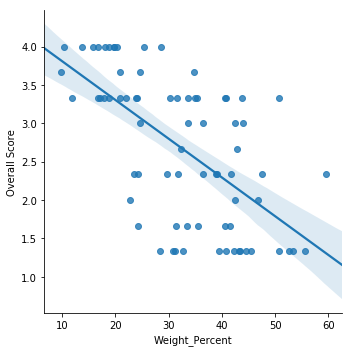

In [314]:
#df_se.plot(kind='scatter', x='Weight_Percent', y='Overall Score')
import seaborn as sns
sns.lmplot(x='Weight_Percent', y='Overall Score', data=df_se, fit_reg=True)

The dataframe obtained shows that while ***Weight_Percent*** increases, the ***Overall Score*** decreases. This is showing also the relation between venues and obesity. Nevertheless we have to be reminded that this subjective classification is merely done to show a relation, but we cannot assure with 100% of certainty which food or venues are good or bad. Anyway, we can find a contrast between the results at the beginning of the table and the ones at the end in our sorted table. the tendency is to find  higher scores where there are low weight percentage values. 

There is also something else that we could do in a next opportunity, as a recommendation, which is to compare this results also with the salary income per region in Chicago, because sometimes certain venues e.g. sushi restaurants are harder to find in places where there are lower incomes. This can also affect the type of venues, food quality, access to Gym and so on.

## 6. Conclusion

This project was aimed to find how venues could affect obesity rates per Community Area in Chicago, so that organizations like CDC can offer solutions knowing that there is a problem in certain community areas with the food that they are consuming, and the lack of physical activity.

In this project we have found that there exists a relation between venues and obesity, in places where people go mostly to gym, they tend to be thinner than where people goes mostly to parks. We have also seen that when it exist different varieties of food, which is also more elaborated (perhaps less fried), obesity rates are lower than in places where the most popular venues are fast food and sandwiches.

This insights are aimed to give tools to the government and CDC to create programs that incentivate people to exercise, perhaps creating more affordable gyms for community areas with less concurrency to these places, as well as make agreements with the owners of fast food venues to help their clients to eat healthier and better.